In [102]:
!pip install shap

In [95]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [96]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from rnn_modeling import Make_DataSet
from visualization import Result_pred, Plot_Result, Monthly_plot, Hourly_plot, TimeBar, Correlation

# Load data

In [50]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Jd.csv')
print(df.shape)
df

(22447, 12)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Visibility,Time,Date,Area,Photovoltaics,Month
0,9.0,2.1,110.0,79.0,1024.1,0.0,2000.0,9,2015-01-25,전남 진도군,13680.0,1
1,10.4,3.0,110.0,77.0,1023.9,0.1,2000.0,10,2015-01-25,전남 진도군,115848.0,1
2,11.2,2.2,180.0,74.0,1023.9,0.0,2000.0,11,2015-01-25,전남 진도군,155016.0,1
3,12.6,1.9,180.0,71.0,1023.0,0.0,2000.0,12,2015-01-25,전남 진도군,175032.0,1
4,12.7,3.2,110.0,73.0,1021.7,0.0,2000.0,13,2015-01-25,전남 진도군,124560.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22442,0.4,1.6,50.0,80.0,1026.0,0.4,1991.0,13,2020-12-31,전남 진도군,210168.0,12
22443,1.6,4.0,320.0,78.0,1025.2,0.1,2000.0,14,2020-12-31,전남 진도군,84528.0,12
22444,2.0,4.4,270.0,67.0,1024.9,0.4,2000.0,15,2020-12-31,전남 진도군,122400.0,12
22445,1.6,5.4,320.0,75.0,1025.1,0.3,1755.0,16,2020-12-31,전남 진도군,129816.0,12


In [51]:
df['Area'].unique()

array(['전남 진도군'], dtype=object)

In [52]:
df['Date'].str[:4].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020'], dtype=object)

# Create Deviation Variable

In [53]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Visibility',
 'Photovoltaics']

In [54]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)



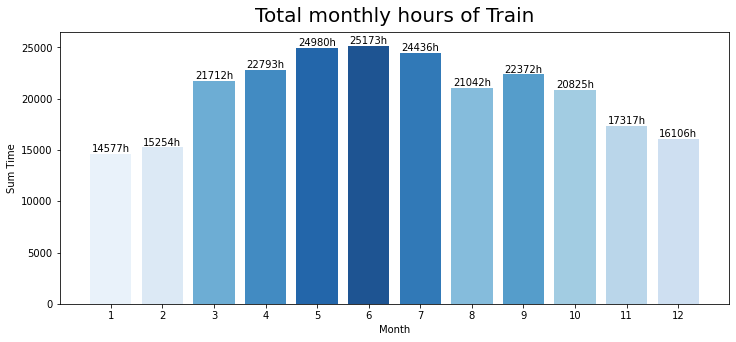

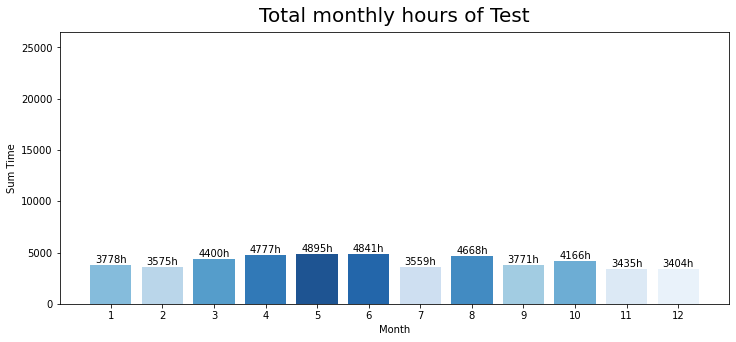

In [55]:
TimeBar(df.loc[:18684-1], 'Train', 26500)
TimeBar(df.loc[18684:], 'Test', 26500)

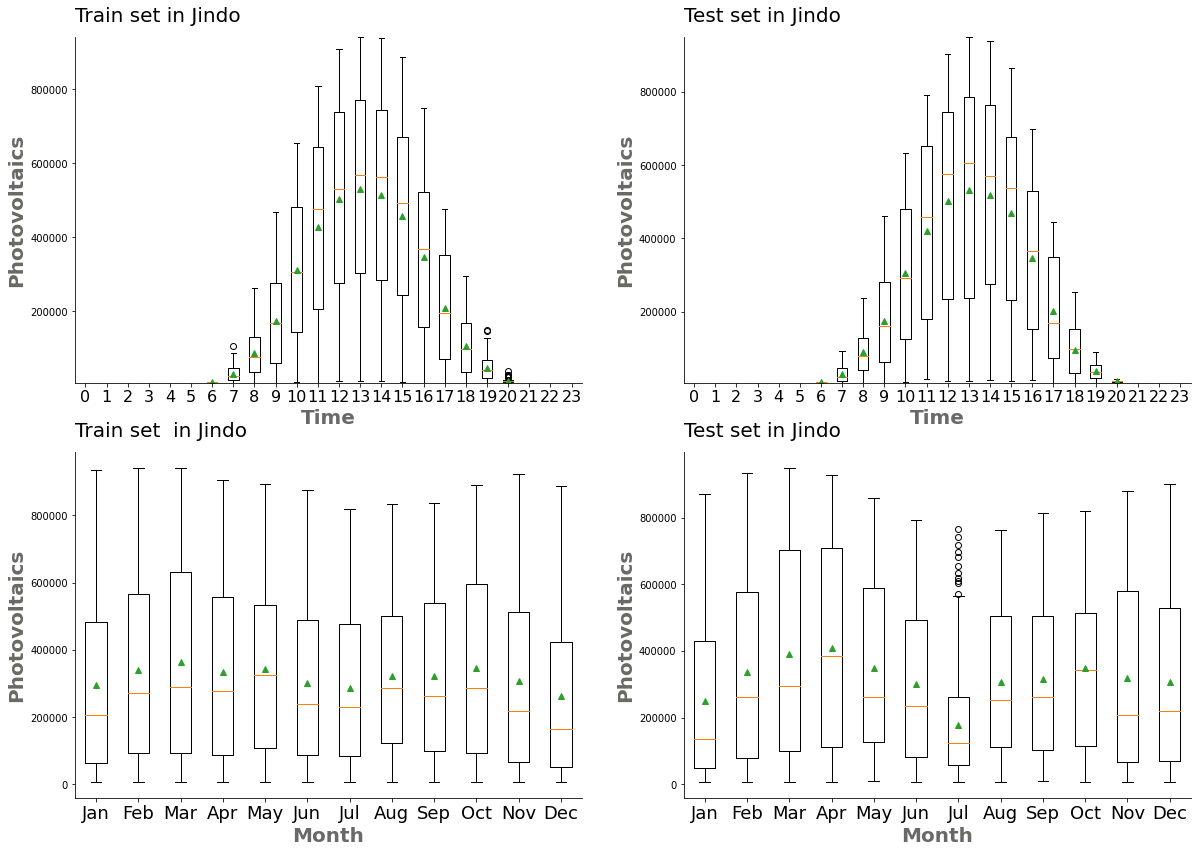

In [56]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
Hourly_plot(df.loc[:18684-1], 'Photovoltaics', ax1, 'Train set in Jindo')
Monthly_plot(df.loc[:18684-1], 'Photovoltaics', ax3, 'Train set  in Jindo')
Hourly_plot(df.loc[18684:], 'Photovoltaics', ax2, 'Test set in Jindo')
Monthly_plot(df.loc[18684:], 'Photovoltaics', ax4, 'Test set in Jindo')

In [57]:
train_Jd = pd.concat([x_train, y_train], axis=1)

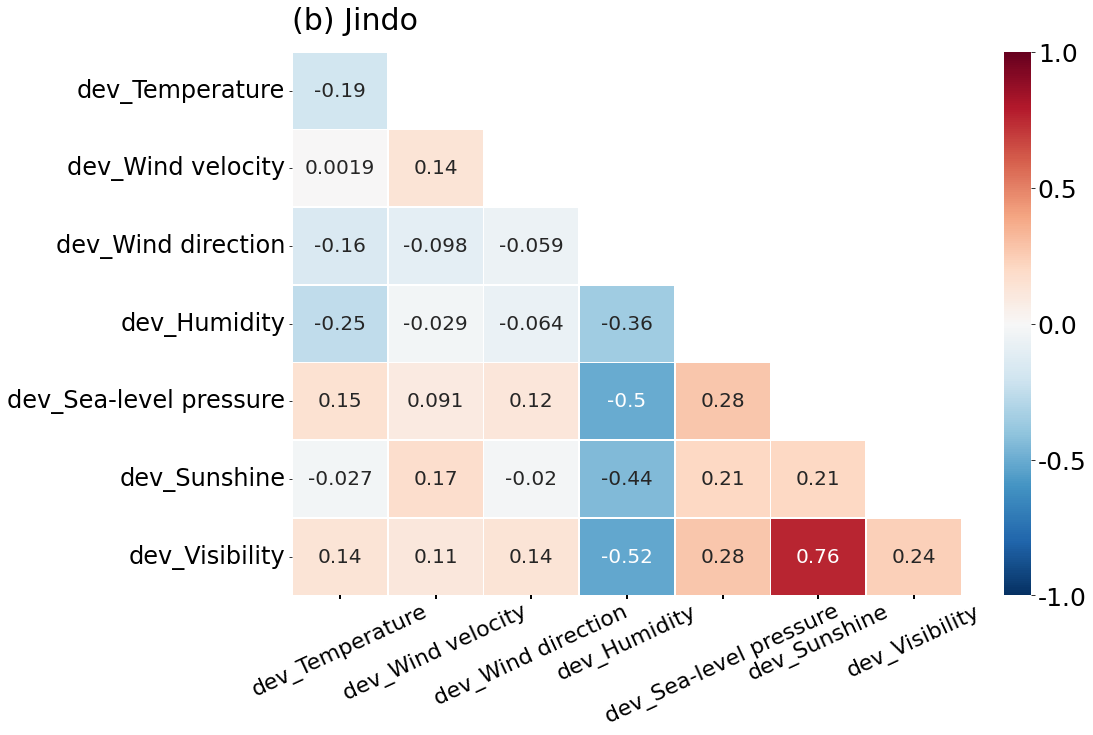

In [88]:
fig, ax1 =  plt.subplots(figsize=(15, 10))
ax1.set_title('(b) Jindo', loc='left', y=1.03, fontsize=30)
c = Correlation(train_Jd, train_Jd.columns, ax1)
fig.savefig('Jd_corr.png',  bbox_inches='tight', pad_inches=0, dpi=100)

# Fine-tuning the model

In [89]:
params = {}

In [ ]:
params = GridSearch_ML(df, cols, params, dev=True)
params = GridSearch_ML(df, cols, params)

In [91]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'max_iter': 4000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [98]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [99]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

LinearRegression()


In [ ]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(500,),
             learning_rate='adaptive', max_iter=4000)


Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


In [ ]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)



Training interrupted by user.


train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)



Training interrupted by user.


train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)



Training interrupted by user.


train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)



Training interrupted by user.


train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(500,),
             learning_rate='adaptive', max_iter=3000)


Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


## LGBM
 (LGBMRegressor)

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)



In [ ]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)



# Score

In [ ]:
score

{'R2_dev_LR': 0.7939252875486553,
 'RMSE_dev_LR': 119786.11811000197,
 'R2_LR': 0.6046859724420341,
 'RMSE_LR': 165907.20711335956,
 'R2_dev_MLP': 0.6900193170097271,
 'RMSE_dev_MLP': 146913.4153922678,
 'R2_dev_LGBM': 0.7783533445722322,
 'RMSE_dev_LGBM': 124229.49818672727}

# Shap plot

In [ ]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

Exact explainer: 18685it [01:42, 167.42it/s]                           


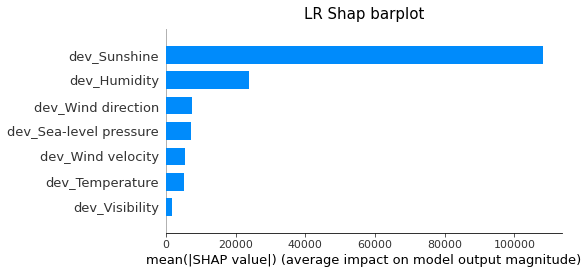

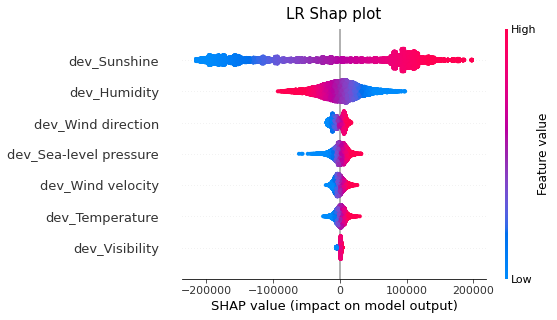

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 18685it [1:08:26,  4.54it/s]


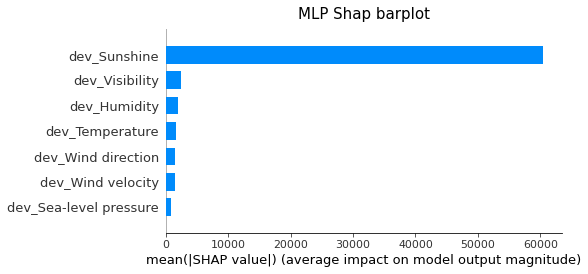

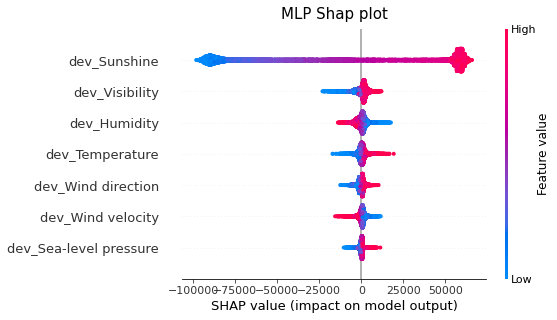

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 18685it [09:14, 33.03it/s]                           


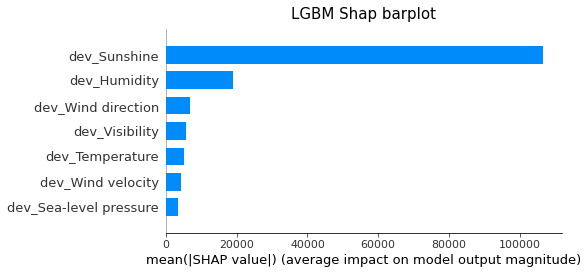

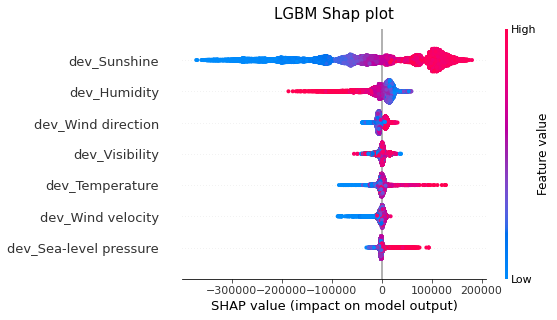

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [100]:
def Shap_feature(model, x_train, model_name, col1, col2):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)
  shap.plots.scatter(shap_values[:,col1], color=shap_values[:,col2])

Exact explainer: 18685it [53:09,  5.84it/s]


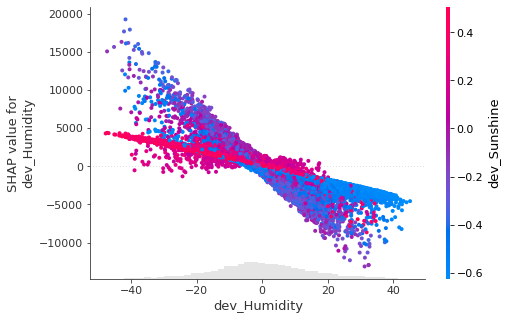

In [ ]:
Shap_feature(**Shap_dic['dev_MLP'], col1='dev_Humidity', col2='dev_Sunshine') 

Exact explainer: 18685it [08:57, 34.05it/s]                           


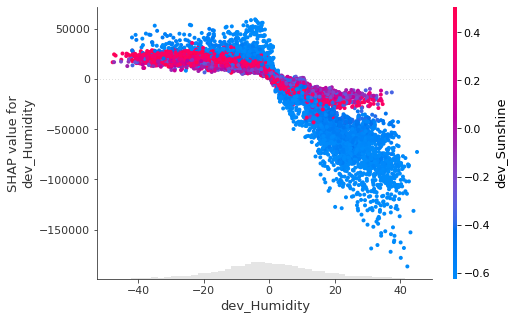

In [ ]:
Shap_feature(**Shap_dic['dev_LGBM'], col1='dev_Humidity', col2='dev_Sunshine') 

Exact explainer: 18685it [02:41, 110.25it/s]                           


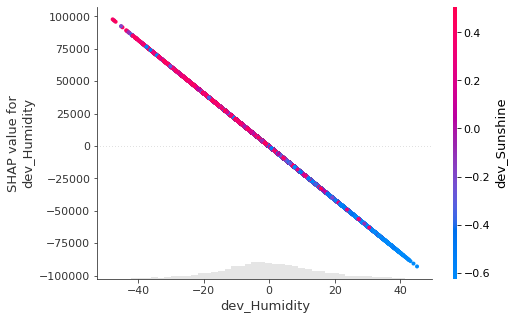

In [101]:
Shap_feature(**Shap_dic['dev_LR'], col1='dev_Humidity', col2='dev_Sunshine')

# Result Plot

In [ ]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)

In [ ]:
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 진도군,2020-01-01,1,9,32184.0,11484.566656,37379.213967,40787.397998,36895.058824
1,전남 진도군,2020-01-01,1,10,178056.0,316244.050778,239397.430916,276354.712094,164703.443478
2,전남 진도군,2020-01-01,1,11,465264.0,501587.557636,419540.560602,452365.512559,344846.571429
3,전남 진도군,2020-01-01,1,12,517824.0,575837.823548,532762.961885,587931.332849,458093.052632
4,전남 진도군,2020-01-01,1,13,559800.0,575529.797060,553403.134944,578735.320778,515935.928571
...,...,...,...,...,...,...,...,...,...
3758,전남 진도군,2020-12-31,12,13,210168.0,318714.426056,403428.679454,393305.423199,448955.234043
3759,전남 진도군,2020-12-31,12,14,84528.0,260168.546460,347295.443130,259483.328997,426334.029851
3760,전남 진도군,2020-12-31,12,15,122400.0,253830.562694,276422.197470,296571.149365,344914.925373
3761,전남 진도군,2020-12-31,12,16,129816.0,55054.503875,85609.352189,67818.913687,163460.117647


In [ ]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

In [ ]:
data.to_csv('/content/gdrive/MyDrive/SolarPower/Jindo_pred.csv')